In [1]:
%matplotlib inline
import matplotlib
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'
from matplotlib import rc
rc('text', usetex=True)

from tqdm import tqdm

from PETITE.shower import *
from PETITE.dark_shower import *

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfontBig=font0.copy()
legfontBig.set_size(18)
legfontBig.set_weight('bold')

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [62]:
MinEnergy = 0.015
sGraphite = DarkShower('/home/pedro/software/PETITE/NBP/', 'graphite', MinEnergy, '10MeV')
Parents = np.load("/home/pedro/software/PETITE/Inputs/Photons_From_Pi0s_120GeV.npy")

NSamp = 5000

PionShower, PionDarkShower = np.array([]), np.array([])
for ni in tqdm(range(NSamp)):
    SMS, BSMS = sGraphite.GenDarkShower(ExDir=None, SParams=[22, Parents[np.random.randint(0, len(Parents))], 111])
    PionShower = np.append(PionShower, SMS)
    PionDarkShower = np.append(PionDarkShower, BSMS)

100%|████████████████████████████████████████████████████████████| 5000/5000 [09:47<00:00,  8.51it/s]


In [63]:
#PionShower = np.load("/Users/kjkelly/Documents/GitHub/PETITE/examples/Outputs/Particles_PionShower_Graphite.npy", allow_pickle=True)
#PionDarkShower = np.load("/Users/kjkelly/Documents/GitHub/PETITE/examples/Outputs/DarkShower_PionShower_10MeV_Graphite.npy", allow_pickle=True)
print(len(PionDarkShower), len(PionShower))

992005 1271029


In [64]:
LDet0, RDet0 = 574.0, 2.5
def RFront(partV, LDet):
    RF = []
    for part in partV:
        x, y, z = part.get_r0()
        E, px, py, pz = part.get_p0()
        RF.append(np.sqrt((x + px/pz*(LDet-z))**2 + (y + py/pz*(LDet-z))**2))
    return np.array(RF)

In [65]:
SMPhotonShower = PionShower[[ps.get_IDs()[0] == 22 for ps in PionShower]]
SMPhotonShowerPass = SMPhotonShower[RFront(SMPhotonShower, LDet0) < RDet0]

PionDarkBrem = PionDarkShower[[ps.get_IDs()[-2] == 0 for ps in PionDarkShower]]
PionDarkBremPass = PionDarkBrem[RFront(PionDarkBrem, LDet0) < RDet0]

In [66]:
print(np.sum([pds.get_IDs()[-1] for pds in SMPhotonShowerPass])/np.sum([pds.get_IDs()[-1] for pds in SMPhotonShower]), np.sum([pds.get_IDs()[-1] for pds in PionDarkBremPass])/np.sum([pds.get_IDs()[-1] for pds in PionDarkBrem]))

0.021508976786377445 0.02170125072933062


In [67]:
PhotonsPerPOT = 2.9 * 2.0 * 0.98823
RWFactor = PhotonsPerPOT/NSamp

In [68]:
def FF(Eg, mV):
    xT = mV/(1.0773*Eg + 0.013716)
    expterm = 1154.0*np.exp(-24.42*xT**0.3174)
    if expterm > 1.0:
        expterm = 1.0
    return expterm

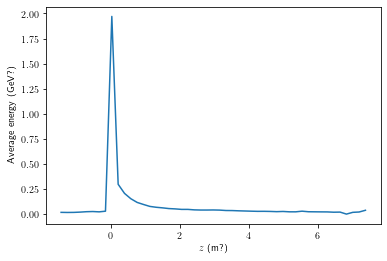

In [106]:
tmp = np.array([[ps.get_p0()[0], ps.get_r0()[2], ps.get_IDs()[-1]] for ps in SMPhotonShower]) # [E, z, weight]
zmin, zmax = np.min(tmp[:,1]), np.max(tmp[:,1])
n_steps=50
zstep = (zmax-zmin)/n_steps
zrange = np.arange(zmin,zmax,zstep)
zvals = (zrange[1:] + zrange[:-1])/2
Emean = np.array([])
for ii in range(len(zvals)):
    tmp2 = np.array([[i[0]*i[2], i[2]] for i in tmp if zrange[ii]<=i[1]<=zrange[ii+1]])
    if len(tmp2)!=0:
        Emean = np.append(Emean, np.sum(tmp2[:,0])/np.sum(tmp2[:,1]))
    else:
        Emean = np.append(Emean, 0)
plt.plot(zvals, Emean)
plt.xlabel(r"$z$ (meter)")
plt.ylabel(r"Average energy (GeV)")
plt.show()

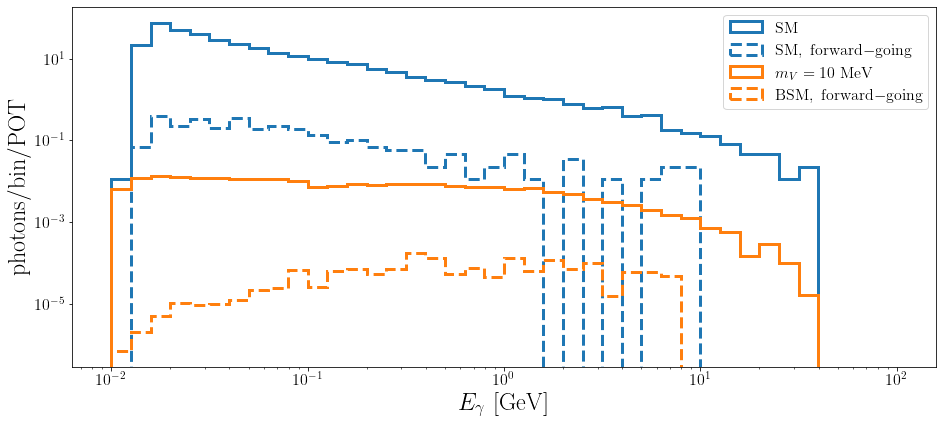

In [11]:
b0 = np.logspace(-2, 2, 41)
SME = [[p0.get_p0()[0], p0.get_IDs()[-1]] for p0 in SMPhotonShower]
SMPE = [[p0.get_p0()[0], p0.get_IDs()[-1]] for p0 in SMPhotonShowerPass]

BSME = [[p0.get_p0()[0], p0.get_IDs()[-1]] for p0 in PionDarkBrem]
BSMPE = [[p0.get_p0()[0], p0.get_IDs()[-1]] for p0 in PionDarkBremPass]

plt.hist(np.transpose(SME)[0], bins=b0, weights=RWFactor*np.transpose(SME)[1], histtype='step', lw=3, color='C0', ls='-', label=r"$\mathrm{SM}$")
plt.hist(np.transpose(SMPE)[0], bins=b0, weights=RWFactor*np.transpose(SMPE)[1], histtype='step', lw=3, color='C0', ls='--', label=r"$\mathrm{SM,\ forward{-}going}$")
plt.hist(np.transpose(BSME)[0], bins=b0, weights=RWFactor*np.transpose(BSME)[1], histtype='step', lw=3, color='C1', ls='-', label=r"$m_V = 10\ \mathrm{MeV}$")
plt.hist(np.transpose(BSMPE)[0], bins=b0, weights=RWFactor*np.transpose(BSMPE)[1], histtype='step', lw=3, color='C1', ls='--', label=r"$\mathrm{BSM,\ forward{-}going}$")

plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin/POT}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(12.0, 5.0)


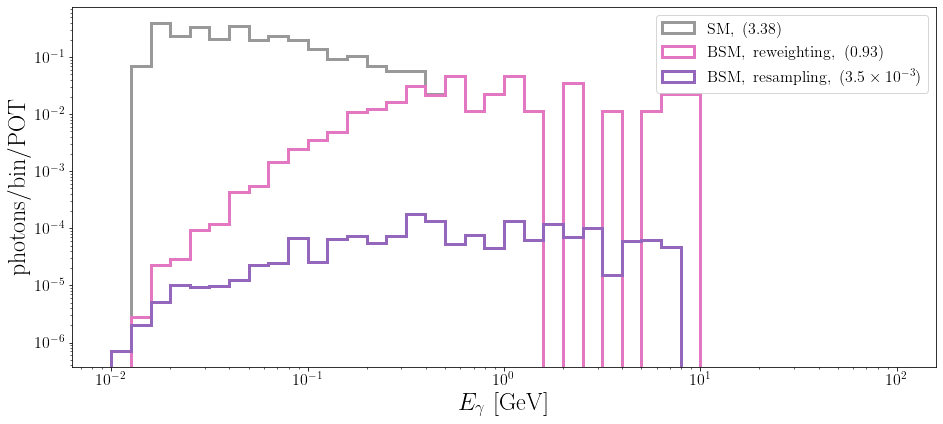

In [10]:
b0 = np.logspace(-2, 2, 41)
SMR = [[sm[0], FF(sm[0], 0.010)*sm[1]] for sm in SMPE]

plt.hist(np.transpose(SMPE)[0], bins=b0, weights=RWFactor*np.transpose(SMPE)[1], histtype='step', lw=3, color='#999999', ls='-', label=r"$\mathrm{SM,\ (3.38)}$")
plt.hist(np.transpose(SMR)[0], bins=b0, weights=RWFactor*np.transpose(SMR)[1], histtype='step', lw=3, color='C6', ls='-', label=r"$\mathrm{BSM,\ reweighting,\ (0.93)}$")
plt.hist(np.transpose(BSMPE)[0], bins=b0, weights=RWFactor*np.transpose(BSMPE)[1], histtype='step', lw=3, color='C4', ls='-', label=r"$\mathrm{BSM,\ resampling,\ (3.5\times 10^{-3})}$")

plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ [\mathrm{GeV}]$", fontsize=24)
plt.gca().set_ylabel(r"$\mathrm{photons/bin/POT}$", fontsize=24)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(16) for l in plt.gca().get_xticklabels()]
[l.set_size(16) for l in plt.gca().get_yticklabels()]

set_size(12.0, 5.0)


In [25]:
print(np.sum(RWFactor*np.transpose(SMPE)[1]), np.sum(RWFactor*np.transpose(SMR)[1]), np.sum(RWFactor*np.transpose(BSMPE)[1]))

3.3817230599999997 0.9266488911875587 0.00354075327599727


In [ ]:
from ipywidgets import IntProgress
from IPython.display import display

ModuleNotFoundError: No module named 'ipywidgets'

In [27]:
BSM3D = [[p0.get_p0()[0], np.sqrt(p0.get_p0()[1]**2 + p0.get_p0()[2]**2)/p0.get_p0()[3], p0.get_IDs()[-1]] for p0 in PionDarkBrem]
SM3D = [[p0.get_p0()[0], np.sqrt(p0.get_p0()[1]**2 + p0.get_p0()[2]**2)/p0.get_p0()[3], p0.get_IDs()[-1]] for p0 in SMPhotonShower]
SM3DRW = [[p0.get_p0()[0], np.sqrt(p0.get_p0()[1]**2 + p0.get_p0()[2]**2)/p0.get_p0()[3], FF(p0.get_p0()[0], 0.010)*p0.get_IDs()[-1]] for p0 in SMPhotonShower]


Text(0.5, 0, '$E_V\\ [\\mathrm{GeV}]$')

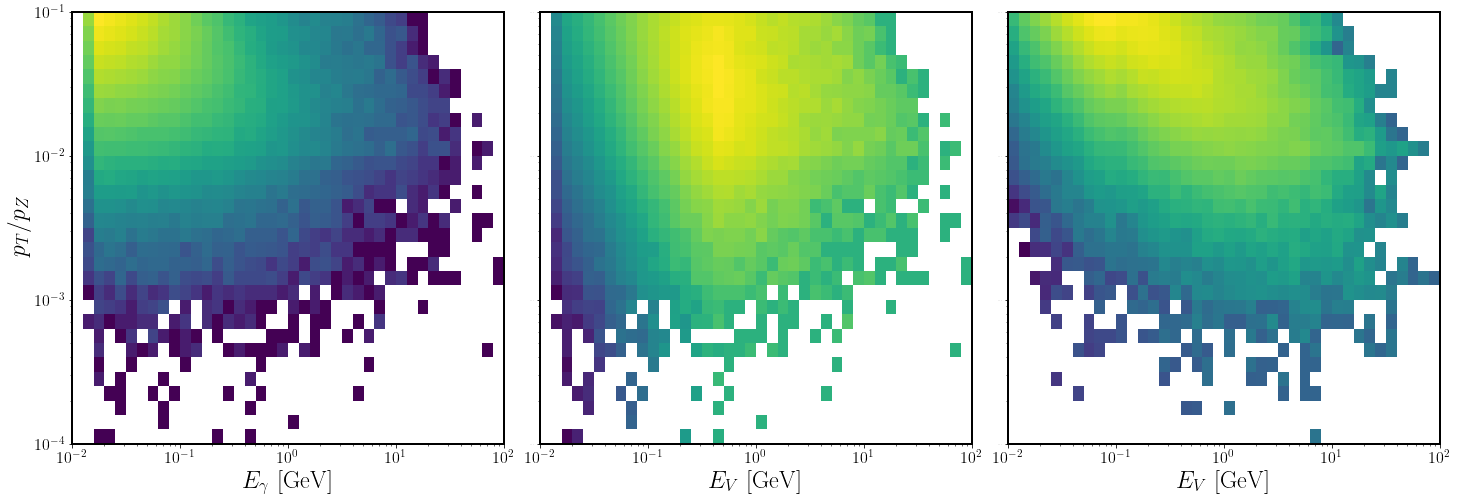

In [28]:
figwid = 6.0
fighei = 6.0
lside = 3.0
rside = 3.5
wwspace = 0.5

ncol = 3
nrow = 1

wid = lside + ncol*figwid + (ncol-1)*wwspace + rside

bot = 3.77
top = 3.5
hhspace = 0.5

hei = bot + nrow*fighei + (nrow-1)*hhspace + top

lfactor = lside/wid
rfactor = rside/wid
bfactor = bot/hei
tfactor = top/hei
wfactor = wwspace/figwid
hfactor = hhspace/fighei

matplotlib.rcParams['axes.linewidth'] = 2.0
fig, axes = plt.subplots(nrow, ncol, figsize=(wid, hei), facecolor='1.0');
fig.subplots_adjust(left = lfactor, bottom=bfactor, right=(1.0-rfactor), top=(1.0-tfactor), wspace=wfactor, hspace=hfactor);

ax = axes[0]
ax.hist2d(np.transpose(SM3D)[0], np.transpose(SM3D)[1], bins=[np.logspace(-2, 2,41), np.logspace(-4,-1,31)], weights=RWFactor*np.transpose(SM3D)[2], norm=matplotlib.colors.LogNorm())

[l.set_size(16) for l in ax.get_xticklabels()]
[l.set_size(16) for l in ax.get_yticklabels()]

#plt.gca().legend(loc=2, fontsize=16)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r"$p_T/p_Z$", fontsize=24)
ax.set_xlabel(r"$E_\gamma\ [\mathrm{GeV}]$", fontsize=24)

ax = axes[1]
ax.hist2d(np.transpose(SM3DRW)[0], np.transpose(SM3DRW)[1], bins=[np.logspace(-2, 2,41), np.logspace(-4,-1,31)], weights=RWFactor*np.transpose(SM3DRW)[2], norm=matplotlib.colors.LogNorm())

[l.set_size(16) for l in ax.get_xticklabels()]
[l.set_size(-1) for l in ax.get_yticklabels()]

#plt.gca().legend(loc=2, fontsize=16)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r"", fontsize=24)
ax.set_xlabel(r"$E_V\ [\mathrm{GeV}]$", fontsize=24)

ax = axes[2]
ax.hist2d(np.transpose(BSM3D)[0], np.transpose(BSM3D)[1], bins=[np.logspace(-2, 2,41), np.logspace(-4,-1,31)], weights=RWFactor*np.transpose(BSM3D)[2], norm=matplotlib.colors.LogNorm())

[l.set_size(16) for l in ax.get_xticklabels()]
[l.set_size(-1) for l in ax.get_yticklabels()]

#plt.gca().legend(loc=2, fontsize=16)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r"", fontsize=24)
ax.set_xlabel(r"$E_V\ [\mathrm{GeV}]$", fontsize=24)

Text(0, 0.5, '$\\mathrm{photons/bin\\ (arb.\\ norm.)}$')

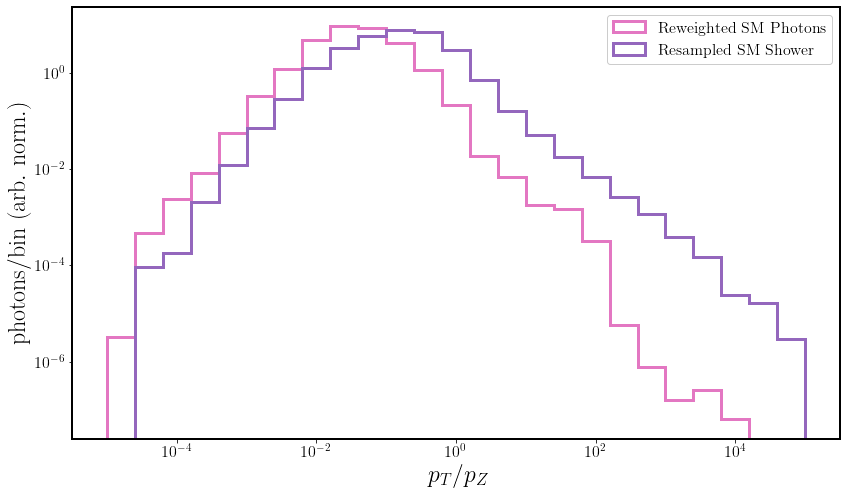

In [54]:
figwid = 6.0*16.0/9.0
fighei = 6.0
lside = 3.0
rside = 3.5
wwspace = 0.5

ncol = 1
nrow = 1

wid = lside + ncol*figwid + (ncol-1)*wwspace + rside

bot = 3.77
top = 3.5
hhspace = 0.5

hei = bot + nrow*fighei + (nrow-1)*hhspace + top

lfactor = lside/wid
rfactor = rside/wid
bfactor = bot/hei
tfactor = top/hei
wfactor = wwspace/figwid
hfactor = hhspace/fighei

matplotlib.rcParams['axes.linewidth'] = 2.0
fig, axes = plt.subplots(nrow, ncol, figsize=(wid, hei), facecolor='1.0');
fig.subplots_adjust(left = lfactor, bottom=bfactor, right=(1.0-rfactor), top=(1.0-tfactor), wspace=wfactor, hspace=hfactor);



ax = axes
#ax.hist(np.transpose(SM3D)[1], bins=np.logspace(-5,5,101), weights=RWFactor*np.transpose(SM3D)[2], histtype='step', lw=3, color='#999999')
ax.hist(np.transpose(SM3DRW)[1], bins=np.logspace(-5,5,26), weights=RWFactor*np.transpose(SM3DRW)[2], histtype='step', lw=3, color='C6', label=r"$\mathrm{Reweighted\ SM\ Photons}$")
ax.hist(np.transpose(BSM3D)[1], bins=np.logspace(-5,5,26), weights=np.sum(RWFactor*np.transpose(SM3DRW)[2])/np.sum(RWFactor*np.transpose(BSM3D)[2])*RWFactor*np.transpose(BSM3D)[2], histtype='step', lw=3, color='C4', label=r"$\mathrm{Resampled\ SM\ Shower}$")

[l.set_size(16) for l in ax.get_xticklabels()]
[l.set_size(16) for l in ax.get_yticklabels()]

ax.legend(loc='best', fontsize=16, framealpha=1.0)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r"$p_T/p_Z$", fontsize=24)
ax.set_ylabel(r"$\mathrm{photons/bin\ (arb.\ norm.)}$", fontsize=24)
